In [5]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import time
import gc
import random
from collections import Counter
from tqdm.notebook import tqdm

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler

# Transformers library for BERT
!pip install -q transformers
# BERT imports
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup# Evaluation libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set random seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For Google Colab, make sure GPU is enabled
if device.type == 'cpu':
    print("WARNING: No GPU detected. For better performance, enable GPU in Colab: Runtime > Change runtime type > Hardware accelerator > GPU")

Using device: cpu


[nltk_data] Downloading package punkt to /Users/ahadm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ahadm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Define data path 
data_path = '/Users/ahadm/Downloads/aclImdb'

# Function to read text files from folders 
def read_text_files(path, limit=None):
    reviews = []
    filenames = os.listdir(path)
    if limit is not None:
        filenames = filenames[:limit]

    for filename in tqdm(filenames):
        if filename.endswith('.txt'):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                reviews.append(file.read())
    return reviews

# Read training data 
print("Reading full training data...")
train_pos_path = os.path.join(data_path, 'train', 'pos')
train_neg_path = os.path.join(data_path, 'train', 'neg')

train_pos_reviews = read_text_files(train_pos_path)  
train_neg_reviews = read_text_files(train_neg_path)

# Read testing data (limited to 5000 samples)
print("Reading testing data ")
test_pos_path = os.path.join(data_path, 'test', 'pos')
test_neg_path = os.path.join(data_path, 'test', 'neg')

test_pos_reviews = read_text_files(test_pos_path, limit=2500)
test_neg_reviews = read_text_files(test_neg_path, limit=2500)

# Create datasets with labels
train_reviews = train_pos_reviews + train_neg_reviews
train_labels = [1] * len(train_pos_reviews) + [0] * len(train_neg_reviews)

test_reviews = test_pos_reviews + test_neg_reviews
test_labels = [1] * len(test_pos_reviews) + [0] * len(test_neg_reviews)

# Shuffle the data
train_data = list(zip(train_reviews, train_labels))
test_data = list(zip(test_reviews, test_labels))

np.random.shuffle(train_data)
np.random.shuffle(test_data)

train_reviews, train_labels = zip(*train_data)
test_reviews, test_labels = zip(*test_data)

# Convert to NumPy arrays
train_reviews = np.array(train_reviews)
train_labels = np.array(train_labels)
test_reviews = np.array(test_reviews)
test_labels = np.array(test_labels)

# Display information about the data
print(f"Number of training reviews: {len(train_reviews)}")
print(f"Number of testing reviews: {len(test_reviews)}")
print(f"Label distribution in training set: Positive={np.sum(train_labels)}, Negative={len(train_labels) - np.sum(train_labels)}")
print(f"Label distribution in testing set: Positive={np.sum(test_labels)}, Negative={len(test_labels) - np.sum(test_labels)}")

Reading full training data...


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

Reading testing data 


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Number of training reviews: 25000
Number of testing reviews: 5000
Label distribution in training set: Positive=12500, Negative=12500
Label distribution in testing set: Positive=2500, Negative=2500


In [7]:
# Function for text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Function for tokenization and stopword removal
def tokenize_and_remove_stopwords(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

# Apply cleaning to all reviews
print("Cleaning training and testing data...")
train_cleaned = [clean_text(review) for review in tqdm(train_reviews)]
test_cleaned = [clean_text(review) for review in tqdm(test_reviews)]

# Split training data into training and validation sets
train_cleaned, val_cleaned, train_labels, val_labels = train_test_split(
    train_cleaned, train_labels, test_size=0.1, random_state=42
)

Cleaning training and testing data...


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
from transformers import BertTokenizer
print("Preparing BERT model...")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Maximum length for reviews 
max_len = 256 

# Function to tokenize and prepare data for BERT
def bert_tokenize(reviews, labels):
    input_ids = []
    attention_masks = []

    for review in tqdm(reviews, desc="Tokenizing"):
        # Encode each review
        encoded_dict = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return input_ids, attention_masks, labels

# Tokenize all data
print("Tokenizing data for BERT...")
train_inputs, train_masks, train_labels_bert = bert_tokenize(train_cleaned, train_labels)
val_inputs, val_masks, val_labels_bert = bert_tokenize(val_cleaned, val_labels)
test_inputs, test_masks, test_labels_bert = bert_tokenize(test_cleaned, test_labels)

# Create DataLoaders
batch_size = 8  
# Create the DataLoader for training set
train_data = TensorDataset(train_inputs, train_masks, train_labels_bert)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels_bert)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for test set
test_data = TensorDataset(test_inputs, test_masks, test_labels_bert)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Preparing BERT model...
Tokenizing data for BERT...


Tokenizing:   0%|          | 0/22500 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/2500 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab
    num_labels=2,  # Binary classification (positive/negative)
    output_attentions=False,  # Whether the model returns attentions weights
    output_hidden_states=False,  # Whether the model returns all hidden-states
)

# Tell pytorch to run this model on the GPU
model = model.to(device)

# Set up optimizer
optimizer = AdamW(model.parameters(),
                  lr=2e-5,  # Learning rate
                  eps=1e-8  # Small value for numerical stability
                 )

# Number of training epochs
epochs = 5

# Total number of training steps is number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to format time
def format_time(elapsed):
    # Round to the nearest second
    elapsed_rounded = int(round(elapsed))
    # Format as hh:mm:ss
    return str(pd.to_datetime(elapsed_rounded, unit='s').strftime('%H:%M:%S'))

Training BERT model...

======== Epoch 1 / 5 ========
Training...
  Batch 40 of 2813. Elapsed: 00:01:10.
  Batch 80 of 2813. Elapsed: 00:02:20.
  Batch 120 of 2813. Elapsed: 00:03:30.
  Batch 160 of 2813. Elapsed: 00:04:40.
  Batch 200 of 2813. Elapsed: 00:05:51.
  Batch 240 of 2813. Elapsed: 00:07:03.
  Batch 280 of 2813. Elapsed: 00:08:15.
  Batch 320 of 2813. Elapsed: 00:09:27.
  Batch 360 of 2813. Elapsed: 00:10:40.
  Batch 400 of 2813. Elapsed: 00:11:53.
  Batch 440 of 2813. Elapsed: 00:13:06.
  Batch 480 of 2813. Elapsed: 00:14:18.
  Batch 520 of 2813. Elapsed: 00:15:31.
  Batch 560 of 2813. Elapsed: 00:16:44.
  Batch 600 of 2813. Elapsed: 00:17:57.
  Batch 640 of 2813. Elapsed: 00:19:10.
  Batch 680 of 2813. Elapsed: 00:20:22.
  Batch 720 of 2813. Elapsed: 00:21:36.
  Batch 760 of 2813. Elapsed: 00:22:50.
  Batch 800 of 2813. Elapsed: 00:24:03.
  Batch 840 of 2813. Elapsed: 00:25:17.
  Batch 880 of 2813. Elapsed: 00:26:30.
  Batch 920 of 2813. Elapsed: 00:27:43.
  Batch 960 of 2

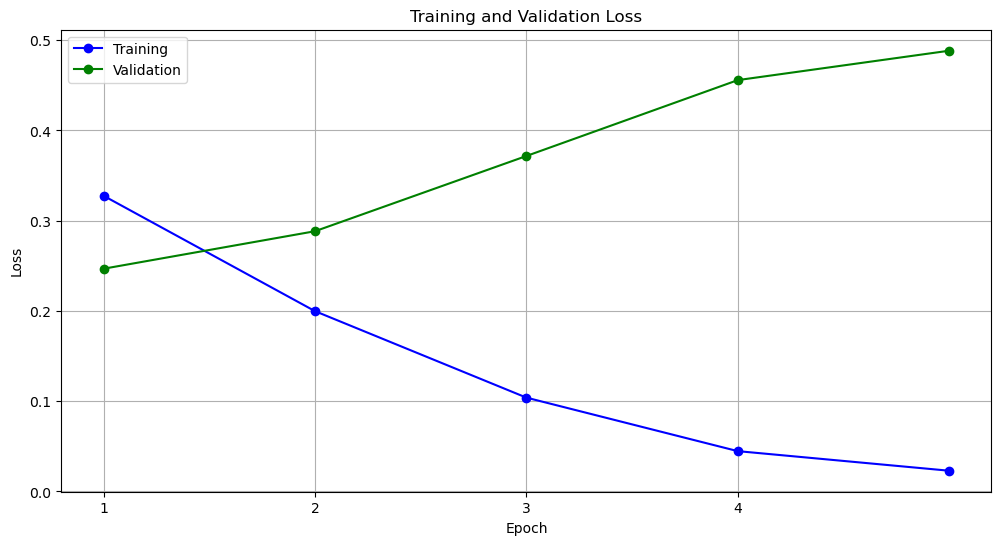

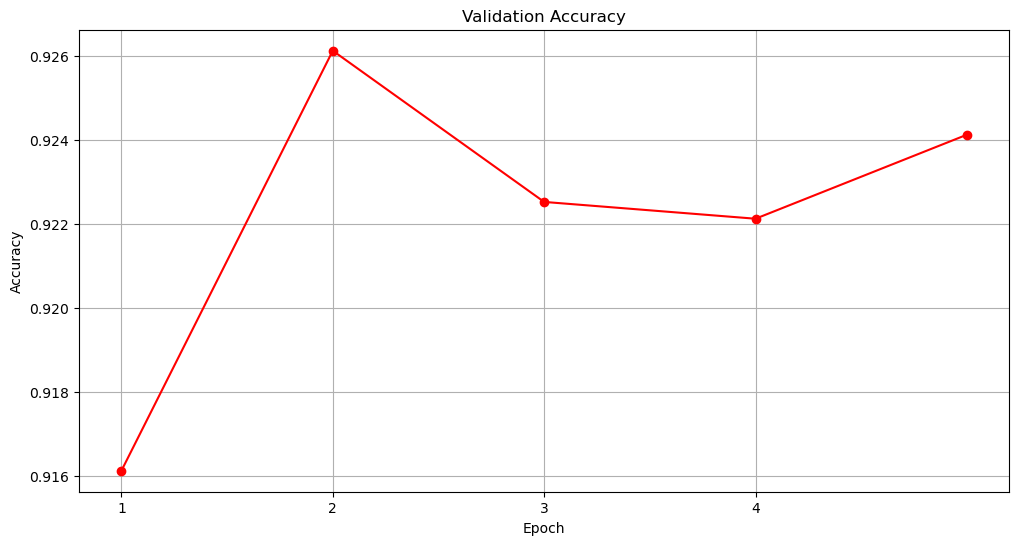

In [13]:
best_val_accuracy = 0.0  
best_val_loss = float('inf')  

# Function to clear GPU memory
def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

# Training loop
print("Training BERT model...")

# Store training statistics
training_stats = []

# Measure total training time
total_t0 = time.time()

for epoch_i in range(0, epochs):٤
    clear_gpu_memory()

    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step} of {len(train_dataloader)}. Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)

    print(f"  Accuracy: {avg_val_accuracy:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation took: {validation_time}")

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

    if (avg_val_accuracy > best_val_accuracy) or \
       (avg_val_accuracy == best_val_accuracy and avg_val_loss < best_val_loss):
        best_val_accuracy = avg_val_accuracy
        best_val_loss = avg_val_loss
        output_dir = "./best_bert_model/"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
        print(f"Best model saved with accuracy: {best_val_accuracy:.4f} and loss: {best_val_loss:.4f}")

    clear_gpu_memory()

print("\nTraining complete!")
print(f"Total training took {format_time(time.time() - total_t0)}")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
print(df_stats)

# Plot training & validation loss values
plt.figure(figsize=(12,6))
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(12,6))
plt.plot(df_stats['Valid. Accur.'], 'r-o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([1, 2, 3, 4])
plt.grid(True)
plt.show()

Evaluating BERT on test set...


Testing:   0%|          | 0/625 [00:00<?, ?it/s]


BERT Model Performance:
Accuracy: 0.9210
Precision: 0.9168
Recall: 0.9260
F1 Score: 0.9214
ROC AUC: 0.9710


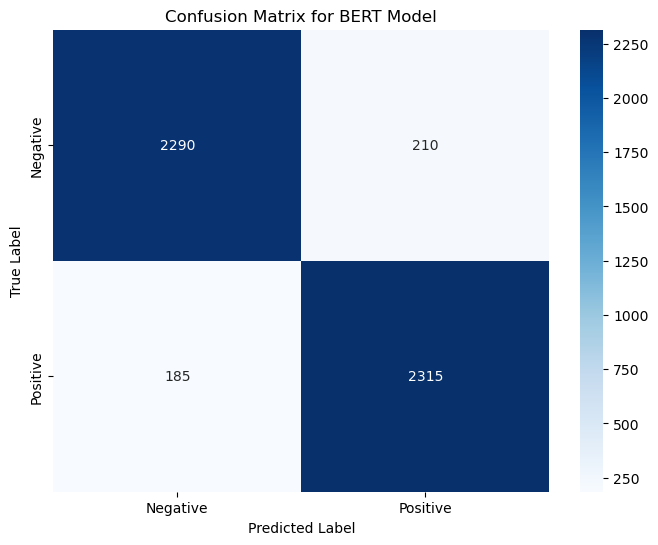

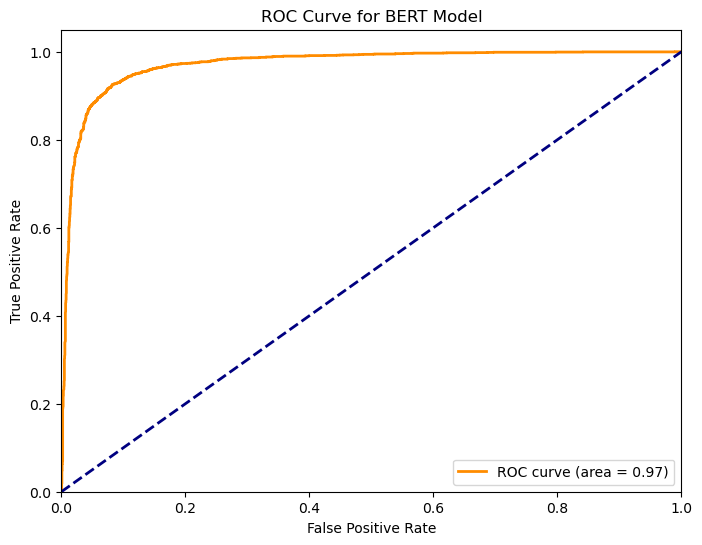


Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      2500
    Positive       0.92      0.93      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



In [14]:
print("Evaluating BERT on test set...")

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in tqdm(test_dataloader, desc="Testing"):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Calculate ROC curve and AUC
# Convert predictions to probabilities for ROC curve
probs = []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
    probs.extend(torch.nn.functional.softmax(logits, dim=1)[:, 1].cpu().numpy())

fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# Print metrics
print(f"\nBERT Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for BERT Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BERT Model')
plt.legend(loc="lower right")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))

In [15]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_path = "./best_bert_model/"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

model.to(device)
model.eval()


def predict_sentiment(review_text):
    encoded_dict = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    probs = torch.softmax(logits, dim=1)
    confidence, pred_label = torch.max(probs, dim=1)
    
    sentiment = 'Positive' if pred_label.item() == 1 else 'Negative'
    return sentiment, confidence.item()


positive_reviews = [
    "This movie was absolutely fantastic! Loved every moment.",
    "An amazing film with brilliant performances and story.",
    "A masterpiece, beautifully directed and acted.",
    "I enjoyed this movie so much, highly recommend it!",
    "Great plot, stunning visuals, and excellent soundtrack."
]


negative_reviews = [
    "This movie was terrible and a complete waste of time.",
    "Poor acting and a boring storyline made it unbearable.",
    "I couldn't finish watching, it was so bad.",
    "Disappointing film with no redeeming qualities.",
    "The plot was confusing and the characters were flat."
]

print("Testing Positive Reviews:\n")
for review in positive_reviews:
    sentiment, confidence = predict_sentiment(review)
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")

print("Testing Negative Reviews:\n")
for review in negative_reviews:
    sentiment, confidence = predict_sentiment(review)
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment} \n")

Testing Positive Reviews:

Review: This movie was absolutely fantastic! Loved every moment.
Predicted Sentiment: Positive (Confidence: 0.9985)

Review: An amazing film with brilliant performances and story.
Predicted Sentiment: Positive (Confidence: 0.9989)

Review: A masterpiece, beautifully directed and acted.
Predicted Sentiment: Positive (Confidence: 0.9991)

Review: I enjoyed this movie so much, highly recommend it!
Predicted Sentiment: Positive (Confidence: 0.9986)

Review: Great plot, stunning visuals, and excellent soundtrack.
Predicted Sentiment: Positive (Confidence: 0.9983)

Testing Negative Reviews:

Review: This movie was terrible and a complete waste of time.
Predicted Sentiment: Negative 

Review: Poor acting and a boring storyline made it unbearable.
Predicted Sentiment: Negative 

Review: I couldn't finish watching, it was so bad.
Predicted Sentiment: Negative 

Review: Disappointing film with no redeeming qualities.
Predicted Sentiment: Negative 

Review: The plot was